In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from simtk import openmm, unit
from harmonic_mixture_sampler import HarmonicSwapper
from free_energy_estimators import MaximumLikelihood
from free_energy_estimators import BayesianSampler

In [11]:
s = (5.0 , 15.0)
sigma1 = s[0] * unit.angstrom
sigma2 = s[1] * unit.angstrom

nsamples = 10000
zetas = range(-5,5)
zetas = [0.0]
n_moves = np.zeros(len(zetas))
n_success = np.zeros(len(zetas))
fraction = np.zeros(len(zetas))
for i in range(len(zetas)):
    swapper = HarmonicSwapper(sigma1, sigma2, zeta = [0.0,zetas[i]])
    swapper.mixture_sample(niterations = nsamples, openmm = False, save_freq = 200)
    n_success[i] = 1.0*swapper.state_counter 
    fraction[i] = 1.0*swapper.state_counter / swapper.nmoves
    n_moves[i] = swapper.nmoves

In [12]:
swapper.nmoves

50

In [13]:
sampler = BayesianSampler(zetas = zetas, nsuccesses = n_success, nsamples = n_moves)
chain = sampler.sample_posterior()

In [14]:
fitter = MaximumLikelihood(zetas = zetas, nsuccesses = n_success, nsamples = n_moves)
f_fit = fitter.max_like()
print f_fit 
print('True free energy difference = {0}'.format( 3*np.log(s[0]/s[1]) ))


-3.17805382954
True free energy difference = -3.295836866


In [15]:
import emcee

def lnprior(f, mean = -2, sigma = 3):
    return -(f**2) / (2.0 * 5) 

def lnprob(f):
    return lnprior(f) + fitter.log_likelihood(f)

In [16]:
ndim, nwalkers = 1, 50
pos = [f_fit + 1e-1*np.random.randn(ndim) for i in range(nwalkers)]

In [17]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
sampler.run_mcmc(pos, 1000)
print np.shape(sampler.chain)
print '# walkers, # samples, # variables'

(50, 1000, 1)
# walkers, # samples, # variables


In [18]:
type(sampler.chain)

numpy.ndarray

View a particular walker

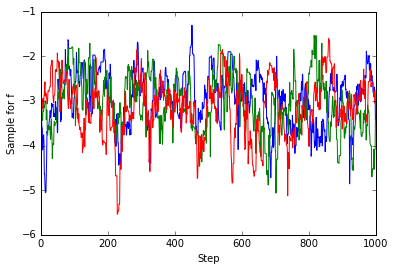

In [19]:
samps_walker1 = sampler.chain[0,:,:]
samps_walker2 = sampler.chain[1,:,:]
samps_walker3 = sampler.chain[2,:,:]

plt.plot(samps_walker1)
plt.plot(samps_walker2)
plt.plot(samps_walker3)

plt.ylabel('Sample for f')
plt.xlabel('Step')
plt.show()

Discarding the 1st 50 samples as 'burn-in' and taking the samples from all the walkers

In [20]:
flat_samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

In [24]:
print 'posterior mean = {0:f} and standard deviation {1:f}'.format(flat_samples.mean(),flat_samples.std())
print 'maximum likelihood estimate {0}'.format( f_fit)
print 'True free energy difference = {0:f}'.format( 3*np.log(s[0]/s[1]) )
print '2.5 percentile', np.percentile(flat_samples,2.5)
print '97.5 percentile', np.percentile(flat_samples,97.5)
print 'Range = ', np.percentile(flat_samples,2.5) - np.percentile(flat_samples,97.5)

posterior mean = -3.056192 and standard deviation 0.656271
maximum likelihood estimate -3.17805382954
True free energy difference = -3.295837
2.5 percentile -4.52214101187
97.5 percentile -1.92838004981
Range =  -2.59376096206


2.5 percentile -4.52214101187
97.5 percentile -1.92838004981
Range =  -2.59376096206


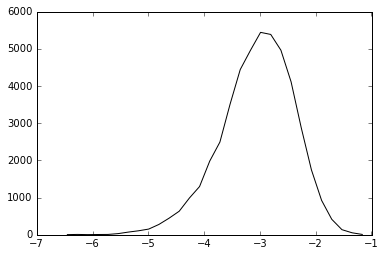

In [23]:
counts, bins = np.histogram(flat_samples,30)
midpoints = bins[0:len(bins)-1] + np.diff(bins)/2.0

plt.clf()
plt.plot(midpoints,counts, color = 'k')
plt.show()

Get a random sample of **f** and sample **zeta**.

In [ ]:
f_samp = np.random.sample(flat_samples,1)

In [ ]:
f_samp = np.random.choice(flat_samples[:,0],size=1)
zeta = np.random.logistic(loc=f_samp)

NameError: name 'median' is not defined